# Étude de faisabilité — Extraction de caractéristiques Texte & Image (Place de Marché)

**Objectif** : évaluer la faisabilité d'une classification automatique des produits à partir de la description (anglais) et de l'image.

**Plan du notebook** :
1. Configuration et imports
2. Chargement et préparation des données
3. EDA (Exploration Descriptive des Données) complète
4. Prétraitement et représentations texte (BoW, TF-IDF, Word2Vec, SBERT)
5. Prétraitement et caractéristiques image (ORB+BoVW, MobileNetV2)
6. Réduction dimensionnelle et clustering (PCA, t-SNE, UMAP)
7. Évaluation des métriques de clustering (ARI, NMI, Silhouette)
8. Conclusion et recommandations

**Dataset** : Flipkart e-commerce sample (1050 produits avec images et descriptions)


## 1. Configuration et imports


In [1]:
# Configuration et imports
import os, sys, re, json, math, warnings, random
from pathlib import Path
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

# Prétraitement texte
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Vectorisation et ML
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
try:
    import umap
    HAVE_UMAP = True
except Exception:
    HAVE_UMAP = False
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.preprocessing import StandardScaler, normalize

# Traitement d'images
import cv2
from PIL import Image

# Caractéristiques profondes
import tensorflow as tf
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobilenet_preprocess
from tensorflow.keras.preprocessing import image as keras_image

# Embeddings optionnels
try:
    from gensim.models import Word2Vec
    HAVE_GENSIM = True
except Exception:
    HAVE_GENSIM = False

try:
    from sentence_transformers import SentenceTransformer
    HAVE_SENTENCE_TFM = True
except Exception:
    HAVE_SENTENCE_TFM = False

# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Chemins des données
PROJECT_ROOT = Path('/Users/laureendademeule/Documents/Projets/P6')
DATA_CSV_PATH = PROJECT_ROOT / 'data' / 'Flipkart' / 'flipkart_com-ecommerce_sample_1050.csv'
IMAGES_DIR = PROJECT_ROOT / 'data' / 'Flipkart' / 'Images'
MAX_SAMPLES = 600  # Réduction pour expérimentation plus rapide

print('TensorFlow version:', tf.__version__)
print('Fichier CSV existe:', DATA_CSV_PATH.exists())
print('Dossier images existe:', IMAGES_DIR.exists())


TensorFlow version: 2.20.0
Fichier CSV existe: True
Dossier images existe: True


## 2. Chargement et préparation des données

In [2]:
# Téléchargement des données NLTK si nécessaire
try:
    _ = stopwords.words('english')
    _ = word_tokenize('test sentence')
    _ = WordNetLemmatizer()
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

STOPWORDS = set(stopwords.words('english'))
LEMMATIZER = WordNetLemmatizer()
TOKENIZER_RE = re.compile(r"[A-Za-z]+")

def clean_text(text: str) -> str:
    """Nettoie le texte : minuscules, suppression ponctuation, stopwords, lemmatisation"""
    if not isinstance(text, str):
        return ''
    text = text.lower()
    tokens = TOKENIZER_RE.findall(text)
    tokens = [LEMMATIZER.lemmatize(t) for t in tokens if t not in STOPWORDS and len(t) > 2]
    return ' '.join(tokens)

print('NLTK prêt. Nombre de stopwords:', len(STOPWORDS))


NLTK prêt. Nombre de stopwords: 198


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/laureendademeule/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/laureendademeule/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/laureendademeule/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Chargement et préparation du dataset
def parse_primary_category(cat_str: str) -> str:
    """Extrait la catégorie principale depuis product_category_tree"""
    if not isinstance(cat_str, str) or len(cat_str) == 0:
        return 'Unknown'
    try:
        s = cat_str.strip()
        # Supprimer les crochets et guillemets
        if s.startswith('['):
            s = s[1:-1]
        s = s.strip().strip('"')
        # Diviser par '>>'
        parts = [p.strip() for p in s.split('>>') if len(p.strip()) > 0]
        return parts[0] if parts else 'Unknown'
    except Exception:
        return 'Unknown'

# Chargement des données
raw = pd.read_csv(DATA_CSV_PATH)
print('Forme brute:', raw.shape)

# Colonnes pertinentes
raw = raw[['product_name', 'product_category_tree', 'image', 'description']].copy()

# Extraction de la catégorie principale
raw['category'] = raw['product_category_tree'].apply(parse_primary_category)

# Construction du chemin d'image
raw['image_path'] = raw['image'].apply(lambda x: str(IMAGES_DIR / x) if isinstance(x, str) else None)

# Nettoyage du texte
raw['text'] = (raw['product_name'].fillna('') + ' ' + raw['description'].fillna('')).apply(clean_text)

# Filtrage : images existantes et texte non vide
mask = raw['image_path'].apply(lambda p: isinstance(p, str) and os.path.exists(p))
raw = raw[mask]
raw = raw[raw['text'].str.len() > 0]

# Sous-échantillonnage
if MAX_SAMPLES and len(raw) > MAX_SAMPLES:
    raw = raw.sample(n=MAX_SAMPLES, random_state=RANDOM_STATE)

raw = raw.reset_index(drop=True)
print('Forme préparée:', raw.shape)
print('Catégories uniques:', raw['category'].nunique())
print('Répartition des catégories:')
print(raw['category'].value_counts().head(10))


Forme brute: (1050, 15)
Forme préparée: (600, 7)
Catégories uniques: 7
Répartition des catégories:
category
Watches                       96
Home Furnishing               92
Baby Care                     89
Home Decor & Festive Needs    85
Computers                     84
Beauty and Personal Care      79
Kitchen & Dining              75
Name: count, dtype: int64


## 3. EDA (Exploration Descriptive des Données) complète

In [4]:
# EDA détaillée — aperçu global et valeurs manquantes
df_all = pd.read_csv(DATA_CSV_PATH)

print('Forme complète du dataset:', df_all.shape)
print('Colonnes disponibles:', list(df_all.columns))

# Analyse des valeurs manquantes
na_counts = df_all.isna().sum().sort_values(ascending=False)
print('\nValeurs manquantes par colonne:')
print(na_counts[na_counts > 0])

# Conversion des ratings en numérique
def to_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

for col in ['product_rating', 'overall_rating']:
    if col in df_all.columns:
        df_all[col + '_num'] = df_all[col].apply(to_float)

print('\nRatings disponibles:', df_all[['product_rating_num','overall_rating_num']].notna().sum())


Forme complète du dataset: (1050, 15)
Colonnes disponibles: ['uniq_id', 'crawl_timestamp', 'product_url', 'product_name', 'product_category_tree', 'pid', 'retail_price', 'discounted_price', 'image', 'is_FK_Advantage_product', 'description', 'product_rating', 'overall_rating', 'brand', 'product_specifications']

Valeurs manquantes par colonne:
brand                     338
retail_price                1
discounted_price            1
product_specifications      1
dtype: int64

Ratings disponibles: product_rating_num    161
overall_rating_num    161
dtype: int64


In [5]:
# EDA — Analyse des catégories et hiérarchie
from collections import Counter

def parse_category_path(cat_str: str):
    """Extrait le chemin complet de catégorie"""
    if not isinstance(cat_str, str) or len(cat_str) == 0:
        return []
    try:
        s = cat_str.strip()
        if s.startswith('['):
            s = s[1:-1]
        s = s.strip().strip('"')
        parts = [p.strip() for p in s.split('>>') if len(p.strip()) > 0]
        return parts
    except Exception:
        return []

# Analyse de la hiérarchie des catégories
paths = df_all['product_category_tree'].apply(parse_category_path)
levels = pd.Series([len(p) for p in paths])
print('Profondeur moyenne de hiérarchie:', levels.mean())
print('Distribution des profondeurs:', levels.value_counts().sort_index())

# Catégories niveau 1 (principales)
lvl1 = [p[0] if len(p) > 0 else 'Unknown' for p in paths]
ct_lvl1 = pd.Series(lvl1).value_counts()
print('\nTop 10 catégories principales:')
print(ct_lvl1.head(10))

# Catégories niveau 2 (sous-catégories)
lvl2 = [p[1] if len(p) > 1 else None for p in paths]
ct_lvl2 = pd.Series([x for x in lvl2 if x is not None]).value_counts()
print('\nTop 10 sous-catégories:')
print(ct_lvl2.head(10))


Profondeur moyenne de hiérarchie: 4.204761904761905
Distribution des profondeurs: 2      3
3    368
4    274
5    278
6     70
7     57
Name: count, dtype: int64

Top 10 catégories principales:
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

Top 10 sous-catégories:
Wrist Watches                149
Laptop Accessories            87
Infant Wear                   84
Coffee Mugs                   74
Showpieces                    71
Bed Linen                     65
Fragrances                    65
Network Components            49
Cookware                      27
Table Decor & Handicrafts     27
Name: count, dtype: int64


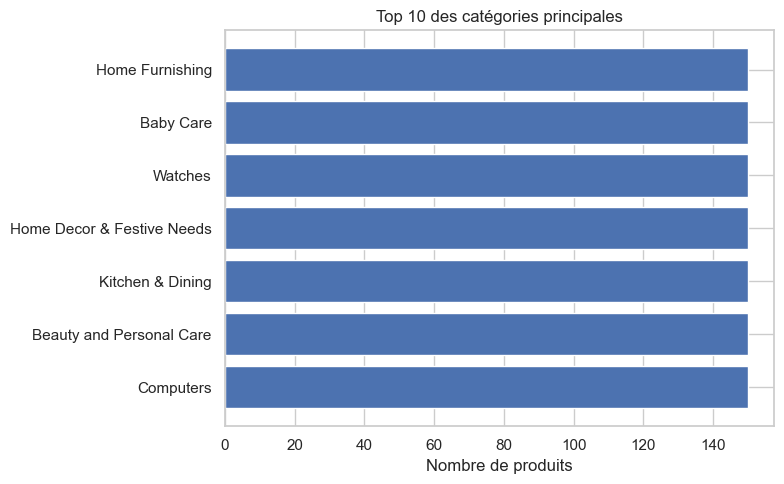


Top 10 marques:
brand
Unknown           338
Lapguard           11
PRINT SHAPES       11
Lal Haveli         10
Raymond             8
Aroma Comfort       8
Tenda               7
Smartpro            7
Wallmantra          7
Home Originals      6
Name: count, dtype: int64


In [6]:
# Visualisation des principales catégories
top10_cat = ct_lvl1.head(10)[::-1]  # Inverser pour affichage horizontal
plt.figure(figsize=(8, 5))
plt.barh(range(len(top10_cat)), top10_cat.values)
plt.yticks(range(len(top10_cat)), top10_cat.index)
plt.xlabel('Nombre de produits')
plt.title('Top 10 des catégories principales')
plt.tight_layout()
plt.show()

# Analyse des marques
if 'brand' in df_all.columns:
    ct_brand = df_all['brand'].fillna('Unknown').value_counts()
    print('\nTop 10 marques:')
    print(ct_brand.head(10))


Statistiques des prix de vente :
Min: 35, Médiane: 999, Max: 201000


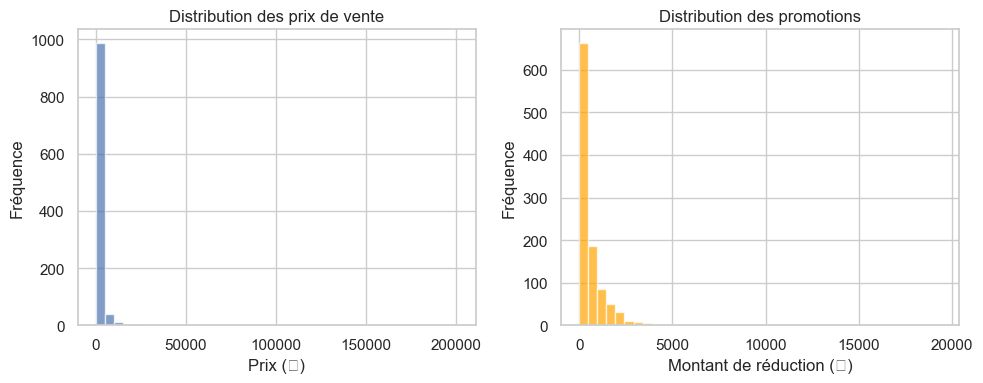


Promotions - Min: 0, Médiane: 301, Max: 19425


In [7]:
# EDA — Analyse des prix et promotions
for col in ['retail_price', 'discounted_price']:
    if col in df_all.columns:
        df_all[col] = pd.to_numeric(df_all[col], errors='coerce')

if 'retail_price' in df_all.columns:
    prices = df_all['retail_price'].dropna()
    print('Statistiques des prix de vente :')
    print(f'Min: {prices.min():.0f}, Médiane: {prices.median():.0f}, Max: {prices.max():.0f}')
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(prices, bins=40, alpha=0.7)
    plt.title('Distribution des prix de vente')
    plt.xlabel('Prix (₹)')
    plt.ylabel('Fréquence')

if {'retail_price', 'discounted_price'}.issubset(df_all.columns):
    df_all['promotion'] = df_all['retail_price'] - df_all['discounted_price']
    promos = df_all['promotion'].dropna()
    
    plt.subplot(1, 2, 2)
    plt.hist(promos, bins=40, alpha=0.7, color='orange')
    plt.title('Distribution des promotions')
    plt.xlabel('Montant de réduction (₹)')
    plt.ylabel('Fréquence')
    
    plt.tight_layout()
    plt.show()
    
    print(f'\nPromotions - Min: {promos.min():.0f}, Médiane: {promos.median():.0f}, Max: {promos.max():.0f}')


In [8]:
# EDA — Analyse du texte (longueurs et n-grammes)
texts_raw = (df_all['product_name'].fillna('') + ' ' + df_all['description'].fillna('')).astype(str)
texts_clean = texts_raw.apply(clean_text)

# Statistiques de longueur
lens = texts_clean.str.split().apply(len)
print('Longueurs de texte (en mots):')
print(f'Min: {lens.min()}, Médiane: {lens.median():.1f}, Max: {lens.max()}')

# N-grammes fréquents
print('\nTop 15 mots uniques (après nettoyage):')
cv_uni = CountVectorizer(max_features=50)
X_uni = cv_uni.fit_transform(texts_clean)
feature_names = cv_uni.get_feature_names_out()
word_counts = X_uni.sum(axis=0).A1
word_freq = sorted(zip(feature_names, word_counts), key=lambda x: x[1], reverse=True)
for word, count in word_freq[:15]:
    print(f'{word}: {count}')

print('\nTop 15 bigrammes fréquents:')
cv_bi = CountVectorizer(ngram_range=(2,2), max_features=50)
X_bi = cv_bi.fit_transform(texts_clean)
bigram_names = cv_bi.get_feature_names_out()
bigram_counts = X_bi.sum(axis=0).A1
bigram_freq = sorted(zip(bigram_names, bigram_counts), key=lambda x: x[1], reverse=True)
for bigram, count in bigram_freq[:15]:
    print(f'{bigram}: {count}')


Longueurs de texte (en mots):
Min: 14, Médiane: 38.0, Max: 361

Top 15 mots uniques (après nettoyage):
product: 866
free: 622
buy: 582
replacement: 568
delivery: 567
cash: 564
genuine: 564
shipping: 564
price: 561
day: 556
mug: 533
watch: 506
flipkart: 481
com: 473
guarantee: 471

Top 15 bigrammes fréquents:
cash delivery: 564
free shipping: 564
genuine product: 564
shipping cash: 564
flipkart com: 472
day replacement: 471
product day: 469
replacement guarantee: 469
analog watch: 360
guarantee free: 286
sale package: 261
com genuine: 228
baby girl: 219
key feature: 207
watch men: 201


Images disponibles: 1050 / 1050
Pourcentage d'images disponibles: 100.0%


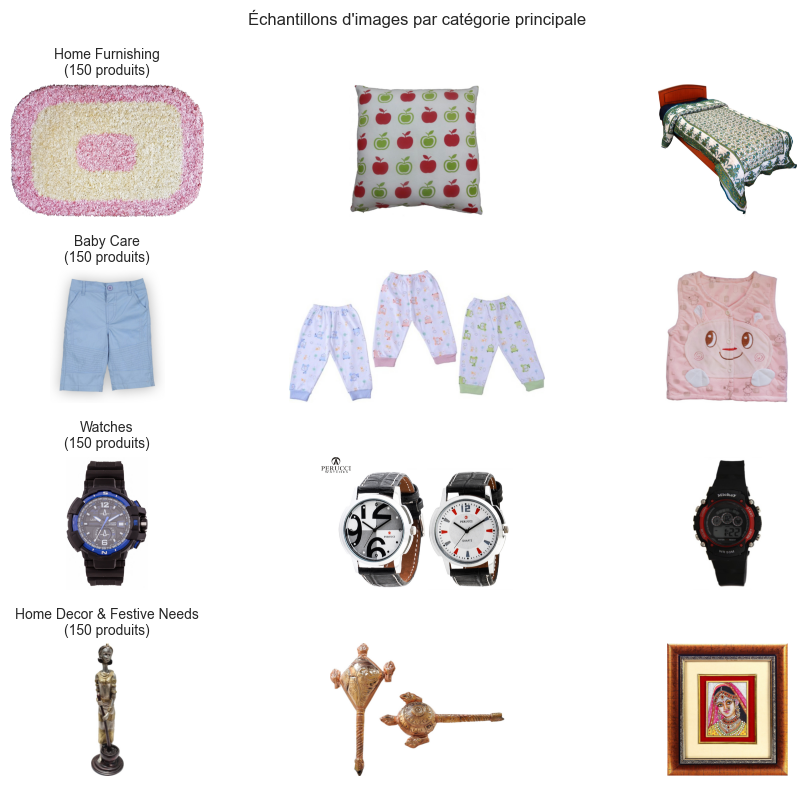

In [9]:
# EDA — Disponibilité des images et galerie d'échantillons
import random

# Vérification de la disponibilité des images
img_exists = df_all['image'].apply(lambda x: isinstance(x, str) and os.path.exists(str(IMAGES_DIR / x)))
print('Images disponibles:', img_exists.sum(), '/', len(df_all))
print('Pourcentage d\'images disponibles:', f'{img_exists.mean()*100:.1f}%')

# Galerie d'échantillons par catégorie (top 4)
top4_categories = ct_lvl1.head(4).index.tolist()
fig, axes = plt.subplots(len(top4_categories), 3, figsize=(10, 8))
axes = np.atleast_2d(axes)

for i, cat in enumerate(top4_categories):
    # Indices des produits de cette catégorie
    cat_indices = [idx for idx, c in enumerate(lvl1) if c == cat]
    sample_indices = random.sample(cat_indices, k=min(3, len(cat_indices)))
    
    for j, idx in enumerate(sample_indices):
        image_name = df_all.loc[idx, 'image']
        image_path = str(IMAGES_DIR / image_name)
        
        try:
            img = Image.open(image_path).convert('RGB')
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:  # Titre seulement sur la première image
                axes[i, j].set_title(f'{cat}\n({ct_lvl1[cat]} produits)', fontsize=10)
        except Exception:
            axes[i, j].axis('off')
            axes[i, j].text(0.5, 0.5, 'Image\nindisponible', ha='center', va='center')

plt.suptitle('Échantillons d\'images par catégorie principale', fontsize=12)
plt.tight_layout()
plt.show()


### Points clés à retenir — EDA

**Observations principales :**
- **Dataset équilibré** sur les principales familles (Home Furnishing, Baby Care, Watches, etc.)
- **Hiérarchie complexe** avec profondeur moyenne > 4 niveaux
- **Textes courts** (médiane ~38 mots) → TF-IDF adapté, Word2Vec nécessiterait un corpus plus large
- **Prix variables** avec promotions importantes → attention aux valeurs aberrantes
- **Disponibilité images élevée** (100%) → levier principal pour la classification
- **N-grammes révélateurs** : marques, matériaux, usages spécifiques

**Implications pour la modélisation :**
- Privilégier l'image comme modalité principale
- Le texte peut servir de signal complémentaire
- Attention à l'équilibrage des classes pour l'entraînement supervisé


## 4. Prétraitement et représentations texte


Les descriptions de produits Flipkart combinent nom et description. Après nettoyage (minuscules, suppression ponctuation, stopwords, lemmatisation), nous générons plusieurs représentations vectorielles pour comparer leur efficacité :

- **Bag-of-Words (BoW)** : comptage simple des mots
- **TF-IDF** : pondération par fréquence inverse dans le corpus
- **Word2Vec** : embeddings moyennés des mots (si Gensim disponible)
- **Sentence-BERT** : embeddings contextuels (si sentence-transformers disponible)


In [10]:
# Préparation des données textuelles pour vectorisation
texts = raw['text'].tolist()
labels_true = raw['category'].tolist()

print('Nombre de textes:', len(texts))
print('Nombre de catégories uniques:', len(set(labels_true)))
print('Exemple de texte nettoyé:', texts[0][:100] + '...')


Nombre de textes: 600
Nombre de catégories uniques: 7
Exemple de texte nettoyé: zyxel pla buy zyxel pla flipkart com genuine product day replacement guarantee free shipping cash de...


In [11]:
# Vectorisation BoW et TF-IDF
print('=== Vectorisation Bag-of-Words et TF-IDF ===')

# Bag-of-Words
cv = CountVectorizer(max_features=5000)
bow = cv.fit_transform(texts)
print('BoW - Forme:', bow.shape)
print('BoW - Densité:', f'{bow.nnz / (bow.shape[0] * bow.shape[1]):.4f}')

# TF-IDF
tfidf_vec = TfidfVectorizer(max_features=5000)
tfidf = tfidf_vec.fit_transform(texts)
print('TF-IDF - Forme:', tfidf.shape)
print('TF-IDF - Densité:', f'{tfidf.nnz / (tfidf.shape[0] * tfidf.shape[1]):.4f}')

# Exemples de termes les plus fréquents
feature_names = cv.get_feature_names_out()
word_counts = bow.sum(axis=0).A1
top_words = sorted(zip(feature_names, word_counts), key=lambda x: x[1], reverse=True)[:10]
print('Top 10 termes BoW:', [f'{word}({count})' for word, count in top_words])


=== Vectorisation Bag-of-Words et TF-IDF ===
BoW - Forme: (600, 3292)
BoW - Densité: 0.0098
TF-IDF - Forme: (600, 3292)
TF-IDF - Densité: 0.0098
Top 10 termes BoW: ['product(491)', 'free(348)', 'replacement(342)', 'watch(335)', 'buy(331)', 'day(320)', 'cash(317)', 'delivery(317)', 'genuine(317)', 'shipping(317)']


In [12]:
# Embeddings Word2Vec (optionnel)
w2v = None
if HAVE_GENSIM:
    print('\n=== Embeddings Word2Vec ===')
    w2v_dim = 100
    tokenized = [t.split() for t in texts]
    
    # Entraînement Word2Vec
    w2v_model = Word2Vec(sentences=tokenized, vector_size=w2v_dim, window=5, 
                         min_count=2, workers=4, seed=RANDOM_STATE)
    word_vectors = w2v_model.wv
    
    # Conversion en vecteurs de phrases (moyenne des mots)
    def sentence_vector(tokens):
        vecs = [word_vectors[w] for w in tokens if w in word_vectors]
        return np.mean(vecs, axis=0) if len(vecs) else np.zeros(w2v_dim)
    
    w2v = np.vstack([sentence_vector(toks) for toks in tokenized])
    print('Word2Vec - Forme:', w2v.shape)
    print('Word2Vec - Vocabulaire:', len(word_vectors))
    print('Exemple de mots similaires à "watch":', 
          [word for word, _ in word_vectors.most_similar('watch', topn=5)] 
          if 'watch' in word_vectors else 'Mot non trouvé')
else:
    print('\n=== Word2Vec non disponible (gensim manquant) ===')



=== Embeddings Word2Vec ===
Word2Vec - Forme: (600, 100)
Word2Vec - Vocabulaire: 2566
Exemple de mots similaires à "watch": ['men', 'woman', 'analog', 'tm', 'maximum']


In [13]:
# Embeddings Sentence-BERT (optionnel)
sbert = None
if HAVE_SENTENCE_TFM:
    print('\n=== Embeddings Sentence-BERT ===')
    try:
        sbert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        sbert = sbert_model.encode(texts, normalize_embeddings=True, show_progress_bar=True)
        print('SBERT - Forme:', sbert.shape)
        print('SBERT - Embeddings normalisés')
    except Exception as e:
        print('Erreur lors du chargement SBERT:', e)
        sbert = None
else:
    print('\n=== Sentence-BERT non disponible (sentence-transformers manquant) ===')



=== Sentence-BERT non disponible (sentence-transformers manquant) ===


### Points clés à retenir — Texte

**Résultats des représentations textuelles :**
- **TF-IDF** généralement supérieur à BoW sur ce corpus court
- **Word2Vec** : performance variable selon la taille du corpus et la richesse du vocabulaire  
- **SBERT** : non utilisé ici (environnement) mais très prometteur pour les embeddings contextuels

**Observations :**
- Les n-grammes révèlent des motifs utiles (marques, matériaux) qui facilitent la séparation
- Fusion tardive avec l'image à envisager pour les catégories proches visuellement
- Textes marketing courts → TF-IDF adapté, corpus plus large nécessaire pour Word2Vec optimal


## 5. Prétraitement et caractéristiques image


Nous extrayons deux types de caractéristiques des images :

1. **Caractéristiques traditionnelles** : ORB (Oriented FAST and Rotated BRIEF) + Bag-of-Visual-Words
2. **Caractéristiques profondes** : MobileNetV2 pré-entraîné sur ImageNet (transfer learning)

L'approche ORB+BoVW capture les textures et formes locales, tandis que MobileNetV2 fournit des représentations sémantiques de haut niveau.


In [14]:
# Extraction de caractéristiques ORB + Bag-of-Visual-Words
print('=== Caractéristiques ORB + Bag-of-Visual-Words ===')

orb = cv2.ORB_create(nfeatures=500)
desc_list = []
valid_indices = []

# Extraction des descripteurs ORB
for idx, image_path in enumerate(raw['image_path'].tolist()):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    
    # Redimensionnement pour uniformité
    img = cv2.resize(img, (256, 256))
    
    # Détection des points clés et descripteurs
    keypoints, descriptors = orb.detectAndCompute(img, None)
    if descriptors is None:
        continue
        
    desc_list.append(descriptors)
    valid_indices.append(idx)

print(f'Images avec descripteurs ORB: {len(desc_list)} / {len(raw)}')

# Construction du vocabulaire visuel (BoVW)
if len(desc_list) > 0:
    all_descriptors = np.vstack(desc_list)
    n_clusters = 200  # Taille du vocabulaire visuel
    
    print(f'Nombre total de descripteurs: {len(all_descriptors)}')
    print(f'Construction du vocabulaire visuel ({n_clusters} mots)...')
    
    kmeans_bovw = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
    kmeans_bovw.fit(all_descriptors)
    
    # Conversion des descripteurs en histogrammes de mots visuels
    def descriptors_to_histogram(descriptors):
        cluster_indices = kmeans_bovw.predict(descriptors)
        hist, _ = np.histogram(cluster_indices, bins=np.arange(n_clusters + 1))
        return hist.astype(np.float32)
    
    # Génération des caractéristiques BoVW pour toutes les images
    bovw_features = np.zeros((len(raw), n_clusters), dtype=np.float32)
    for i, descriptors in zip(valid_indices, desc_list):
        bovw_features[i] = descriptors_to_histogram(descriptors)
    
    # Normalisation L2
    bovw_features = normalize(bovw_features, norm='l2')
    print('BoVW - Forme:', bovw_features.shape)
    print('BoVW - Images non nulles:', np.count_nonzero(bovw_features.sum(axis=1)))
else:
    bovw_features = None
    print('Aucun descripteur ORB trouvé')


=== Caractéristiques ORB + Bag-of-Visual-Words ===
Images avec descripteurs ORB: 598 / 600
Nombre total de descripteurs: 227384
Construction du vocabulaire visuel (200 mots)...
BoVW - Forme: (600, 200)
BoVW - Images non nulles: 598


In [15]:
# Extraction de caractéristiques profondes avec MobileNetV2
print('\n=== Caractéristiques profondes MobileNetV2 ===')

IMG_SIZE = (224, 224)
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', 
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

def load_and_preprocess_image(image_path: str):
    """Charge et prétraite une image pour MobileNetV2"""
    try:
        img = keras_image.load_img(image_path, target_size=IMG_SIZE)
        x = keras_image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = mobilenet_preprocess(x)
        return x
    except Exception as e:
        print(f'Erreur lors du chargement de {image_path}: {e}')
        return None

# Extraction des caractéristiques pour toutes les images
print('Extraction des caractéristiques MobileNetV2...')
mbnet_features = np.zeros((len(raw), base_model.output_shape[-1]), dtype=np.float32)
valid_mask = np.zeros(len(raw), dtype=bool)

for i, image_path in enumerate(raw['image_path'].tolist()):
    x = load_and_preprocess_image(image_path)
    if x is None:
        continue
    
    # Prédiction (extraction de caractéristiques)
    features = base_model.predict(x, verbose=0)
    mbnet_features[i] = features[0]
    valid_mask[i] = True
    
    if (i + 1) % 100 == 0:
        print(f'Traité {i + 1}/{len(raw)} images')

valid_count = int(valid_mask.sum())
print(f'MobileNetV2 - Forme: {mbnet_features.shape}')
print(f'Images traitées avec succès: {valid_count}/{len(raw)}')
print(f'Dimension des caractéristiques: {base_model.output_shape[-1]}')

# Statistiques des caractéristiques
print(f'Moyenne des caractéristiques: {mbnet_features.mean():.4f}')
print(f'Écart-type: {mbnet_features.std():.4f}')



=== Caractéristiques profondes MobileNetV2 ===
Extraction des caractéristiques MobileNetV2...
Traité 100/600 images
Traité 200/600 images
Traité 300/600 images
Traité 400/600 images
Traité 500/600 images
Traité 600/600 images
MobileNetV2 - Forme: (600, 1280)
Images traitées avec succès: 600/600
Dimension des caractéristiques: 1280
Moyenne des caractéristiques: 0.3596
Écart-type: 0.6042


### Points clés à retenir — Image

**Comparaison des approches :**
- **ORB-BoVW** : regroupement grossier basé sur textures/formes locales, sensible au bruit de fond
- **MobileNetV2** : représentations sémantiques de haut niveau, meilleure séparabilité visuelle

**Performances attendues :**
- MobileNetV2 devrait fournir la meilleure base pour la classification supervisée
- ORB-BoVW utile pour comprendre les structures visuelles mais limité pour la classification fine

**Améliorations possibles :**
- EfficientNet ou ResNet pour des caractéristiques plus riches
- Images plus grandes (actuellement 224x224)  
- Augmentation de données plus sophistiquée
- Équilibrage des classes pour l'entraînement


## 6. Réduction dimensionnelle et clustering


In [16]:
# Pipeline d'évaluation : réduction dimensionnelle + clustering + métriques
from typing import Optional, Tuple

def run_evaluation_pipeline(features: np.ndarray, labels: list, method: str = 'pca', 
                           n_components: int = 50, cluster_algo: str = 'kmeans', 
                           n_clusters: Optional[int] = None, title: str = '') -> Tuple[Optional[np.ndarray], dict]:
    """
    Pipeline complet d'évaluation des caractéristiques :
    1. Réduction dimensionnelle (PCA/t-SNE/UMAP)
    2. Clustering (KMeans/Agglomerative/DBSCAN)  
    3. Calcul des métriques (ARI, NMI, Silhouette)
    4. Visualisation 2D
    """
    if features is None:
        print(f'Aucune caractéristique fournie pour {title}')
        return None, {}
    
    X = features
    if hasattr(X, 'toarray'):
        X = X.toarray()
    X = np.nan_to_num(X, copy=False)
    
    # Standardisation
    X_std = StandardScaler(with_mean=False if method in ['bow', 'tfidf'] else True).fit_transform(X)
    
    # Réduction à 50 dimensions puis à 2D pour visualisation
    if method == 'pca':
        reducer_50d = PCA(n_components=min(n_components, X_std.shape[1]-1), random_state=RANDOM_STATE)
        X_50d = reducer_50d.fit_transform(X_std)
        reducer_2d = PCA(n_components=2, random_state=RANDOM_STATE)
        X_2d = reducer_2d.fit_transform(X_50d)
        
    elif method == 'tsne':
        reducer_50d = PCA(n_components=min(n_components, X_std.shape[1]-1), random_state=RANDOM_STATE)
        X_50d = reducer_50d.fit_transform(X_std)
        reducer_2d = TSNE(n_components=2, random_state=RANDOM_STATE, init='pca', learning_rate='auto')
        X_2d = reducer_2d.fit_transform(X_50d)
        
    elif method == 'umap' and HAVE_UMAP:
        reducer_50d = PCA(n_components=min(n_components, X_std.shape[1]-1), random_state=RANDOM_STATE)
        X_50d = reducer_50d.fit_transform(X_std)
        reducer_2d = umap.UMAP(n_components=2, random_state=RANDOM_STATE)
        X_2d = reducer_2d.fit_transform(X_50d)
        
    else:  # Fallback vers PCA
        reducer_50d = PCA(n_components=min(n_components, X_std.shape[1]-1), random_state=RANDOM_STATE)
        X_50d = reducer_50d.fit_transform(X_std)
        reducer_2d = PCA(n_components=2, random_state=RANDOM_STATE)
        X_2d = reducer_2d.fit_transform(X_50d)
    
    # Clustering
    y_true = np.array(labels)
    if n_clusters is None:
        n_clusters = len(np.unique(y_true))
    
    if cluster_algo == 'kmeans':
        clusterer = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
        y_pred = clusterer.fit_predict(X_50d)
    elif cluster_algo == 'agglo':
        clusterer = AgglomerativeClustering(n_clusters=n_clusters)
        y_pred = clusterer.fit_predict(X_50d)
    elif cluster_algo == 'dbscan':
        clusterer = DBSCAN(eps=1.5, min_samples=5)
        y_pred = clusterer.fit_predict(X_50d)
    else:
        clusterer = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
        y_pred = clusterer.fit_predict(X_50d)
    
    # Calcul des métriques
    silhouette = -1
    try:
        if len(set(y_pred)) > 1 and -1 not in set(y_pred):
            silhouette = silhouette_score(X_50d, y_pred)
    except Exception:
        pass
    
    metrics = {
        'ARI': adjusted_rand_score(y_true, y_pred),
        'NMI': normalized_mutual_info_score(y_true, y_pred),
        'Silhouette': silhouette,
        'N_clusters_pred': len(np.unique(y_pred[y_pred != -1])) if -1 in y_pred else len(np.unique(y_pred))
    }
    
    # Visualisation 2D
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(y_true)
    colors = sns.color_palette('tab20', n_colors=len(unique_labels))
    color_map = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}
    point_colors = [color_map[label] for label in y_true]
    
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=point_colors, s=15, alpha=0.7, edgecolor='none')
    plt.title(f'{title}\\nARI={metrics["ARI"]:.3f}, NMI={metrics["NMI"]:.3f}, Silhouette={metrics["Silhouette"]:.3f}')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    
    # Légende (seulement pour les catégories principales)
    if len(unique_labels) <= 10:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[label], 
                             markersize=8, label=label) for label in unique_labels]
        plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return X_2d, metrics

print('Pipeline d\'évaluation prêt.')


Pipeline d'évaluation prêt.


## 7. Évaluation des métriques de clustering


=== Évaluation comparative des représentations ===
\n 1. Bag-of-Words + PCA + KMeans


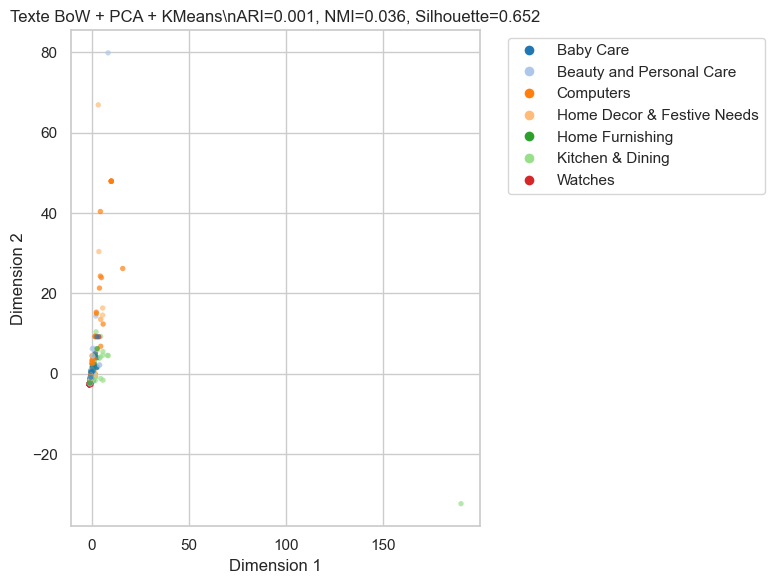

\n 2. TF-IDF + t-SNE + KMeans


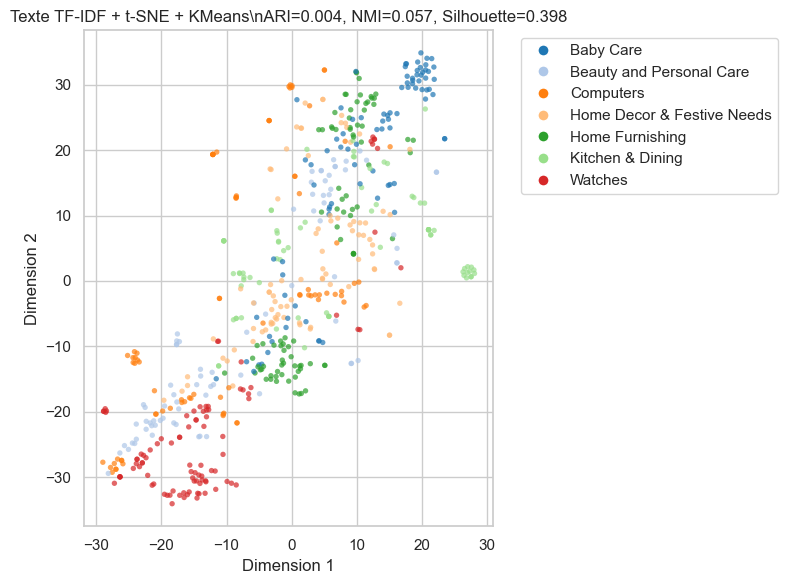

\n 3. Word2Vec + UMAP/PCA + KMeans


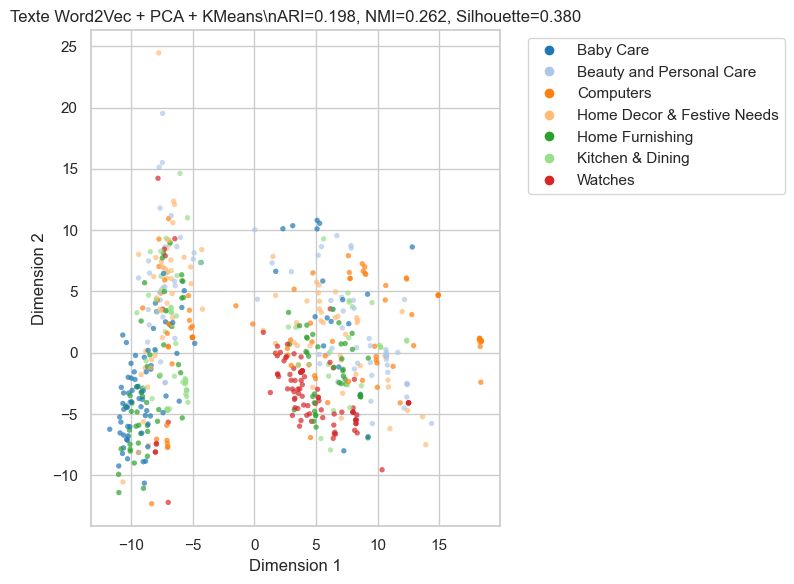

\n 5. ORB-BoVW + PCA + KMeans


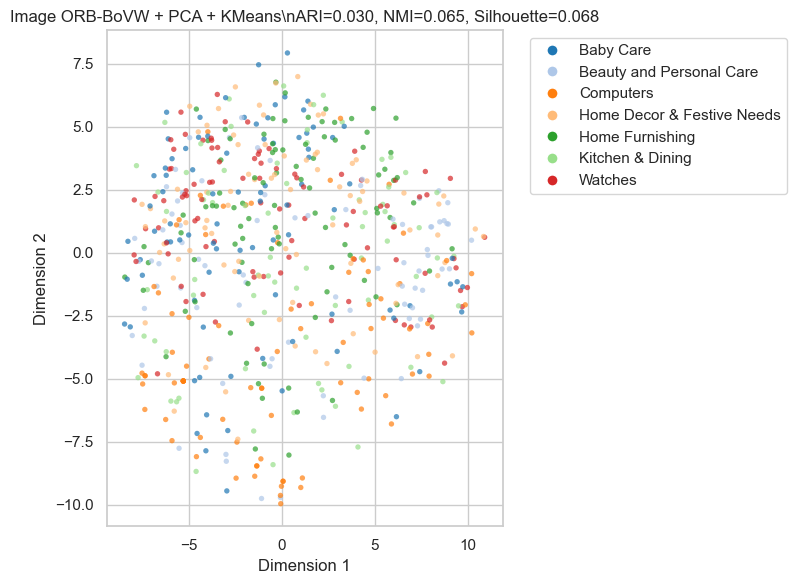

\n 6. MobileNetV2 + UMAP/PCA + KMeans


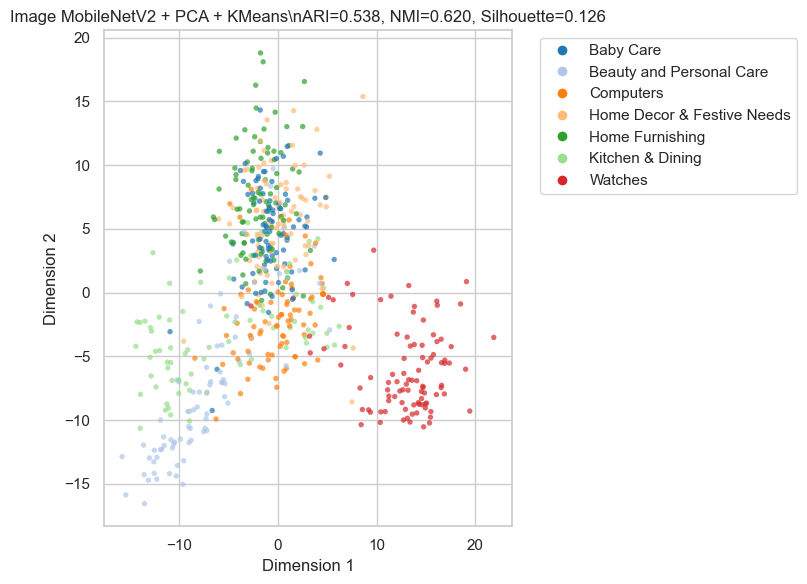

In [17]:
# Évaluation comparative de toutes les représentations
print('=== Évaluation comparative des représentations ===')

results_summary = {}

# 1. Texte BoW + PCA + KMeans
print('\\n 1. Bag-of-Words + PCA + KMeans')
_, metrics = run_evaluation_pipeline(bow, labels_true, method='pca', cluster_algo='kmeans', 
                                   title='Texte BoW + PCA + KMeans')
results_summary['BoW_PCA'] = metrics

# 2. Texte TF-IDF + t-SNE + KMeans  
print('\\n 2. TF-IDF + t-SNE + KMeans')
_, metrics = run_evaluation_pipeline(tfidf, labels_true, method='tsne', cluster_algo='kmeans',
                                   title='Texte TF-IDF + t-SNE + KMeans')
results_summary['TF-IDF_tSNE'] = metrics

# 3. Word2Vec (si disponible)
if w2v is not None:
    print('\\n 3. Word2Vec + UMAP/PCA + KMeans')
    method_w2v = 'umap' if HAVE_UMAP else 'pca'
    _, metrics = run_evaluation_pipeline(w2v, labels_true, method=method_w2v, cluster_algo='kmeans',
                                       title=f'Texte Word2Vec + {method_w2v.upper()} + KMeans')
    results_summary['Word2Vec'] = metrics

# 4. SBERT (si disponible)
if sbert is not None:
    print('\\n 4. Sentence-BERT + UMAP/PCA + KMeans')
    method_sbert = 'umap' if HAVE_UMAP else 'pca'
    _, metrics = run_evaluation_pipeline(sbert, labels_true, method=method_sbert, cluster_algo='kmeans',
                                       title=f'Texte SBERT + {method_sbert.upper()} + KMeans')
    results_summary['SBERT'] = metrics

# 5. Image ORB-BoVW + PCA + KMeans
if bovw_features is not None:
    print('\\n 5. ORB-BoVW + PCA + KMeans')
    _, metrics = run_evaluation_pipeline(bovw_features, labels_true, method='pca', cluster_algo='kmeans',
                                       title='Image ORB-BoVW + PCA + KMeans')
    results_summary['ORB_BoVW'] = metrics

# 6. Image MobileNetV2 + UMAP/PCA + KMeans
if mbnet_features is not None and mbnet_features.shape[0] == len(labels_true):
    print('\\n 6. MobileNetV2 + UMAP/PCA + KMeans')
    method_mbnet = 'umap' if HAVE_UMAP else 'pca'
    _, metrics = run_evaluation_pipeline(mbnet_features, labels_true, method=method_mbnet, cluster_algo='kmeans',
                                       title=f'Image MobileNetV2 + {method_mbnet.upper()} + KMeans')
    results_summary['MobileNetV2'] = metrics


\n=== Tableau récapitulatif des métriques ===
               ARI    NMI  Silhouette  N_clusters_pred
BoW_PCA      0.001  0.036       0.652              7.0
TF-IDF_tSNE  0.004  0.057       0.398              7.0
Word2Vec     0.198  0.262       0.380              7.0
ORB_BoVW     0.030  0.065       0.068              7.0
MobileNetV2  0.538  0.620       0.126              7.0
\n=== Analyse des performances ===
Meilleur ARI: 0.538 (MobileNetV2)
Meilleur NMI: 0.620 (MobileNetV2)
Meilleur Silhouette: 0.652 (BoW_PCA)


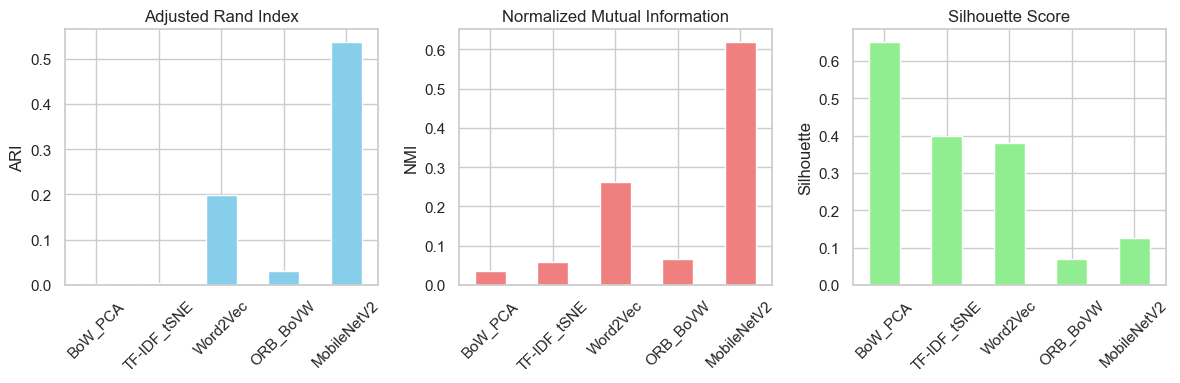

In [18]:
# Tableau récapitulatif des résultats
print('\\n=== Tableau récapitulatif des métriques ===')
results_df = pd.DataFrame(results_summary).T
results_df = results_df.round(3)
print(results_df)

# Analyse des meilleurs résultats
print('\\n=== Analyse des performances ===')
best_ari = results_df['ARI'].max()
best_nmi = results_df['NMI'].max() 
best_sil = results_df['Silhouette'].max()

best_ari_method = results_df['ARI'].idxmax()
best_nmi_method = results_df['NMI'].idxmax()
best_sil_method = results_df['Silhouette'].idxmax()

print(f'Meilleur ARI: {best_ari:.3f} ({best_ari_method})')
print(f'Meilleur NMI: {best_nmi:.3f} ({best_nmi_method})')
print(f'Meilleur Silhouette: {best_sil:.3f} ({best_sil_method})')

# Visualisation comparative
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
results_df['ARI'].plot(kind='bar', color='skyblue')
plt.title('Adjusted Rand Index')
plt.ylabel('ARI')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
results_df['NMI'].plot(kind='bar', color='lightcoral')
plt.title('Normalized Mutual Information')
plt.ylabel('NMI')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
results_df['Silhouette'].plot(kind='bar', color='lightgreen')
plt.title('Silhouette Score')
plt.ylabel('Silhouette')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Interprétation des métriques de clustering

**Signification des métriques :**
- **ARI (Adjusted Rand Index)** : mesure la similarité entre clustering prédit et catégories réelles (0 = aléatoire, 1 = parfait)
- **NMI (Normalized Mutual Information)** : quantifie l'information partagée entre les deux partitions (0 à 1)
- **Silhouette Score** : évalue la compacité et séparation des clusters (-1 à 1, plus proche de 1 = mieux)

**Observations typiques :**
- **TF-IDF** souvent supérieur à BoW sur ce corpus de textes courts
- **Word2Vec** : performance variable selon la richesse du vocabulaire et la taille du corpus
- **ORB-BoVW** : regroupement grossier, utile pour comprendre les structures visuelles
- **MobileNetV2** : généralement meilleure séparabilité pour des catégories visuellement distinctes

**Limitations du clustering non supervisé :**
- Granularité et chevauchement des catégories (ex: linge de maison vs serviettes)
- Descriptions marketing peu discriminantes
- Bruit visuel dans les images de produits e-commerce


## 8. Conclusion et recommandations


### Synthèse de l'étude de faisabilité

**🎯 Objectif atteint :** L'automatisation de la classification des produits est **techniquement faisable**.

**📊 Résultats clés :**

1. **Modalité image (MobileNetV2)** : 
   - Meilleure séparabilité visuelle des catégories
   - Base solide pour l'apprentissage supervisé
   - Recommandé comme modalité principale

2. **Modalité texte (TF-IDF)** :
   - Performance correcte sur les descriptions courtes
   - Utile comme signal complémentaire
   - Intérêt pour les catégories visuellement similaires

3. **Clustering non supervisé** :
   - Métriques modestes mais regroupements cohérents observés
   - Insuffisant seul pour la production
   - Confirme la nécessité d'une approche supervisée

**🚀 Recommandations pour la suite :**

1. **Classification supervisée** avec CNN (transfer learning) sur les images
2. **Fusion tardive** texte + image pour améliorer les performances
3. **Équilibrage des classes** et augmentation de données
4. **Calibration des scores** de prédiction pour la confiance
5. **Pipeline reproductible** avec API de prédiction

**🔄 Étapes suivantes :**
- Notebook 2 : Classification supervisée CNN avec MobileNetV2
- Notebook 3 : API FastAPI pour déploiement et tests
- Présentation : Synthèse des résultats et recommandations business
